In [58]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # This is to disable GPU
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0" 

import numpy as np
import datetime as datetime
import pandas as pd
import tensorflow as tf
from datetime import datetime
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
from sklearn.metrics import r2_score
import importlib
import swifter
import plot_functions
import ml_wrappers
import functions
import pytplot
from pyspedas import time_double
from pyspedas import time_string
import sys
import warnings


# warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

random_seed = 42

tf.random.set_seed(random_seed)
np.random.seed(random_seed)
np.set_printoptions(precision=4)

importlib.reload(ml_wrappers)

<module 'ml_wrappers' from '/home/jliao/workspace/GitHub/inner_magnetosphere_ann/ml_wrappers.py'>

In [3]:
main_dir = ''

data_dir = main_dir+'data/'
os.makedirs(data_dir, exist_ok = True) 
model_dir = main_dir+'model/'
os.makedirs(model_dir, exist_ok = True)
result_dir = main_dir+'test_results/'
os.makedirs(result_dir, exist_ok = True) 

average_time = 300

plot_inputs = False

dL01 = True

In [4]:
# Read in data, 5 minutes resolution data, including omni data and cluster data. 
df_a= pd.read_csv(data_dir+'rbspA_data_fulldata.csv')  
df_a['probe'] = 'a'
df_b= pd.read_csv(data_dir+'rbspB_data_fulldata.csv')  
df_b['probe'] = 'b'

df_full = pd.concat([df_a, df_b], ignore_index=True) # all data
del df_a, df_b
df_full['Datetime'] = df_full['time'].swifter.apply(time_string)

Dask Apply:   0%|          | 0/40 [00:00<?, ?it/s]

In [5]:
# set up the parameters and y that are used in the code
coor_names = ["cos0", 'sin0', 'scaled_lat','scaled_l']
feature_names = [ 'scaled_symh', 'scaled_ae','scaled_asyh', 'scaled_asyd'] #,'scaled_swp', 'scaled_bz'] #, 'scaled_f107', 'scaled_kp']

y_names_total = [['log_h_flux_972237','log_o_flux_972237'], ['log_h_flux_9631899','log_o_flux_9631899'],['log_h_flux_51767680','log_o_flux_51767680']]
y_names = y_names_total[2]

y_names_original = [s.replace("log_","") for s in y_names]
#y_name_original = y_name.replace("log_","")

models =  [model_dir + s + '.h5' for s in y_names]

In [6]:
# extract the length the parameters
m_coor = len(coor_names)
m_y = len(y_names)
m_feature = len(feature_names)
# For each feature, we will add 2 hours earlier of the parametners: feature_1 no delay, feautre_2, 2 hours before the observing time, feature_3, 4 hours before the observation time.
# Time reslution is set to be two hours for each feature and 
n_history_total_days = 6
n_history_total = n_history_total_days*24*60*60/average_time 

m_history = int(n_history_total/24 + 1)

# m is the total number of parameters including features and y
m = m_feature * m_history + m_coor + m_y

In [7]:
## There are non valid data in the situ observations, index data and solar wind data. Indexes of valid data are created. We have previousely reviewed that all coordinates data and all indexes data do not have NaN or Inf data. 
index_good_index = (df_full['ae'] > 0)
index_good_sw = np.isfinite(df_full['swp']) & np.isfinite(df_full['bz'])
index_good_y = np.isfinite(df_full[y_names_original[0]]) & np.isfinite(df_full[y_names_original[1]]) & (df_full[y_names_original[0]] > 0) & (df_full[y_names_original[1]] > 0) # we take out 0 measurement data because we are using the log

# if we decide to use solar wind parameters, we need to add index_good_sw
index_good = index_good_y & index_good_index 

In [8]:
# Code to to keep only 1 data sample per 0.1 L shell, set dL01=True 
if (dL01):
    df_full["l10"] = df_full["l"].swifter.apply(lambda x: np.floor(x*10))
    df_full["l10_pre"] = np.append(0,np.array(df_full.loc[0:(df_full.shape[0]-2), "l10"]))
    df_full['isMask'] = df_full["l10"] ==  df_full["l10_pre"]
    index_good = index_good & ~df_full['isMask']
# df_full[['l','l10','l10_pre','isMask']]

In [9]:
n_sample = sum(index_good)
print('Total number of valid 5-minutes samples is:', n_sample)

# create time_array for plotting the data
time_array = df_full.loc[index_good,'Datetime'].astype('datetime64[ns]').reset_index(drop=True)

# View the summary of the datetime. Makesure that the first date of the valid data has enough history days.
df_full.loc[index_good, 'Datetime']

Total number of valid 5-minutes samples is: 695796


3840       2013-01-14 08:02:30.000000
3841       2013-01-14 08:07:30.000000
3843       2013-01-14 08:17:30.000000
3845       2013-01-14 08:27:30.000000
3846       2013-01-14 08:32:30.000000
                      ...            
1313850    2019-03-31 23:32:30.000000
1313851    2019-03-31 23:37:30.000000
1313852    2019-03-31 23:42:30.000000
1313853    2019-03-31 23:47:30.000000
1313854    2019-03-31 23:52:30.000000
Name: Datetime, Length: 695796, dtype: object

In [10]:
## Take log10 for the flux. This step is essential 
# df_full[y_names] = df_full.loc[:,y_names_original].apply(lambda x: np.log10(x*1e3*4*math.pi))
df_full[y_names] = df_full.loc[index_good,y_names_original].swifter.apply(lambda x: np.log10(x*1e3*4*math.pi))

# visualize plasma data
if (plot_inputs):
    plot_functions.view_data(df_full,index_good, [y_names_original[iy],y_names[iy],y_names_original[iy], y_names[iy]], ['H+ 51767.680 eV','log H+ 51767.680 eV','O+ 51767.680 eV','log O+ 51767.680 eV'], time_array, figname = result_dir + 'rbsp')

In [11]:
#Scale coordinates L, cos(theta),sin(theta),Lat. All are scaled linearly to [-1,1]
df_full['cos0'] = df_full['mlt'].swifter.apply(lambda x: np.cos(x*np.pi/12.0))
df_full['sin0'] = df_full['mlt'].swifter.apply(lambda x: np.sin(x*np.pi/12.0))
df_full.loc[index_good, 'scaled_l'] = functions.scale_arr(df_full.loc[index_good, 'l']) # here only scales the good data
df_full.loc[index_good, 'scaled_lat'] = functions.scale_arr(df_full.loc[index_good, 'lat'])# here only scales the good data

if (plot_inputs):
    plot_functions.view_data(df_full,index_good, ['mlt',"cos0",'sin0','l','scaled_l','lat','scaled_lat'], ['MLT','cos theta','sin theta','L','scaled L','LAT','scaled LAT'], time_array, figname = result_dir + 'coor')

7.826034587546741 1.12850076193702 4.4772676747418805 6.697533825609721
19.92544708333316 -19.85855629142716 0.033445395953000556 39.78400337476032


In [12]:
#Scale indexes
df_full['scaled_symh'] = functions.scale_arr(df_full['symh'])
df_full['scaled_asyh'] = functions.scale_arr(df_full['asyh'])
df_full['scaled_asyd'] = functions.scale_arr(df_full['asyd'])
df_full['scaled_ae'] = functions.scale_arr(df_full['ae'])
df_full['scaled_f107'] = functions.scale_arr(df_full['f10.7'])
df_full['scaled_kp'] = functions.scale_arr(df_full['kp'])

if (plot_inputs):
    plot_functions.view_data(df_full,index_good, ['symh',"scaled_symh",'asyh','scaled_asyh','asyd','scaled_asyd','ae','scaled_ae','f10.7','scaled_f107','scaled_kp','kp'], ['Sym-H', "Scaled Sym-H", 'Asy-H','Scaled Asy-H','Asy-D','Scaled Asy-D','AE','Scaled AE','F10.7','Scaled F10.7', 'Scaled KP','KP'], time_array, figname = result_dir + 'omni')

78.0 -232.8000030517578 -77.4000015258789 310.8000030517578
348.0 0.0 174.0 348.0
379.0 0.0 189.5 379.0
2471.39990234375 3.400000095367432 1237.3999512195587 2467.9999022483826
255.0 64.5999984741211 159.79999923706055 190.4000015258789
8.3 0.0 4.15 8.3


In [13]:
#Scale solar wind drivers
df_full['scaled_swp'] = functions.scale_arr(df_full['swp'])
df_full['scaled_swn'] = functions.scale_arr(df_full['swn'])
df_full['scaled_swv'] = functions.scale_arr(df_full['swv'])
df_full['scaled_by'] = functions.scale_arr(df_full['by'])
df_full['scaled_bz'] = functions.scale_arr(df_full['bz'])

# Visualize solar wind drivers
if (plot_inputs):
    plot_functions.view_data(df_full,index_good, ['swp',"scaled_swp",'swn','scaled_swn','swv','scaled_swv','by','scaled_by',"bz","scaled_bz"], ['SW P','scaled SW P','SW N','scaled SW N','SW V','scaled SW V','IMF By','scaled IMF By','IMF Bz','scaled IMF Bz'], time_array, figname = result_dir + 'sw')

56.76599884033203 0.050000000745058 28.407999420538545 56.71599883958697
72.12999725341797 0.1359999924898148 36.13299862295389 71.99399726092815
927.0999755859376 243.6999969482422 585.3999862670898 683.3999786376954
32.51399993896484 -27.52799987792969 2.493000030517573 60.04199981689453
31.9219970703125 -38.81400299072266 -3.4460029602050817 70.73600006103516


In [14]:
# calculate history of the solar wind driver and geomagentic indexes

history_resolution = 2 * 3600.
index_difference = history_resolution/average_time
history_feature_names = ["" for x in range(len(feature_names)*m_history)]
ihf= 0
index0 = n_history_total
index1 = df_full.index[-1]

for feature_name in feature_names:
    for k in range(m_history):
        name = feature_name + '_' + str(k*2)+'h'
        history_feature_names[ihf] = name
        df_full.loc[index0:index1,name] = np.array(df_full.loc[(index0 - index_difference*k):(index1-index_difference*k), feature_name])  
        ihf = ihf + 1
        
## This method is slow but good if different history calculation is wanted
# def calculate_history(x, df_full, feature_name):
#     index = df_full['time'] == (x-history_resolution)
#     return(float(df_full.loc[index,feature_name]))

# history_resolution = 2 * 3600.
# for feature_name in feature_names:
#     print(feature_name)
#     for k in range(m_history):
#         print(k)
#         name = feature_name + '_' + str(k*2)+'h'
#         df[name] = df.loc[:,'time'].swifter.apply(calculate_history, df_full = df_full,feature_name = feature_name)  

In [15]:
#set test set. Here we use one year (2017) of data for test set 
index_train, index_valid,index_test =  ml_wrappers.create_ml_indexes(df_full, '2017-01-01', '2018-01-01', index_good, train_size=0.8)


463252 116606 115938


In [16]:
# importlib.reload(ml_wrappers)

# Each round, one can only train one y. If train more than one y, need to  repeat from here
x_train, x_valid, x_test, y_train, y_valid, y_test = ml_wrappers.create_ml_data(df_full, index_train, index_valid,index_test, y_names, coor_names, history_feature_names)

3624/3624 [==============================] - 2s 448us/step


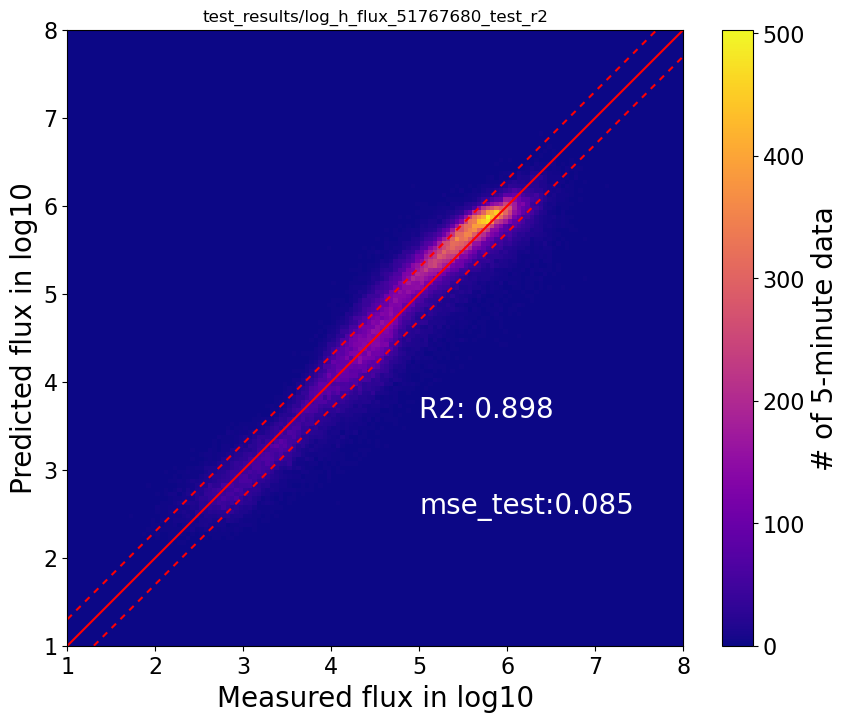

3624/3624 [==============================] - 2s 442us/step


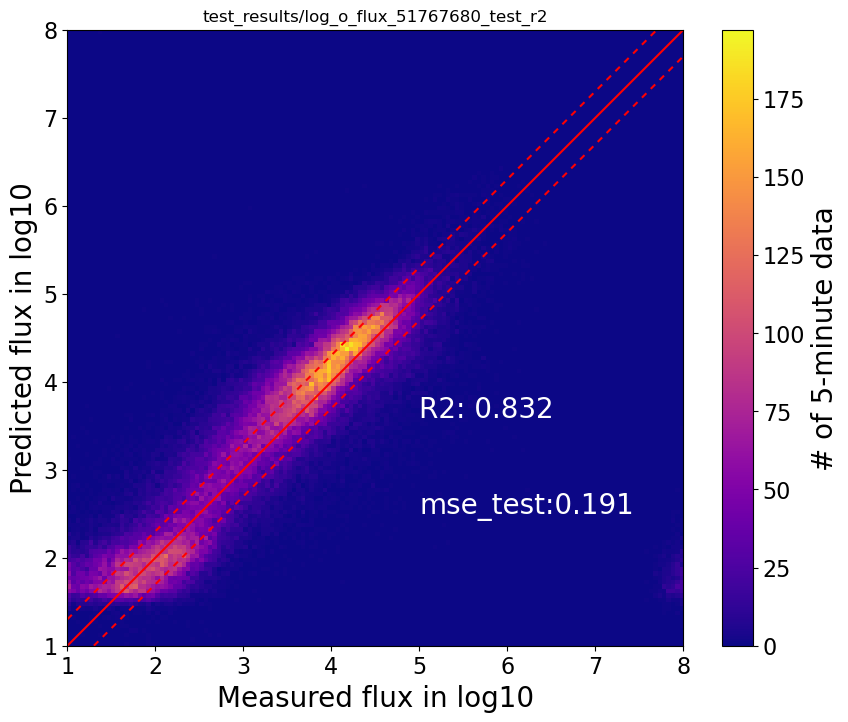

In [105]:
importlib.reload(plot_functions)
# calculate test result

inner_model = list()
y_test_pred = list()
y_test_pred_reshaped = list()
for iy in range(len(y_names)):
    inner_model.append(tf.keras.models.load_model(models[iy]))
    
    y_test_pred.append(inner_model[iy].predict(x_test))
    y_test_pred_reshaped.append(y_test_pred[iy].reshape([-1]))
    plot_functions.plot_correlation_heatmap(y_test[:,iy], y_test_pred[iy].reshape([-1]), xrange=[1,8], figname = result_dir + y_names[iy]+'_test_r2')



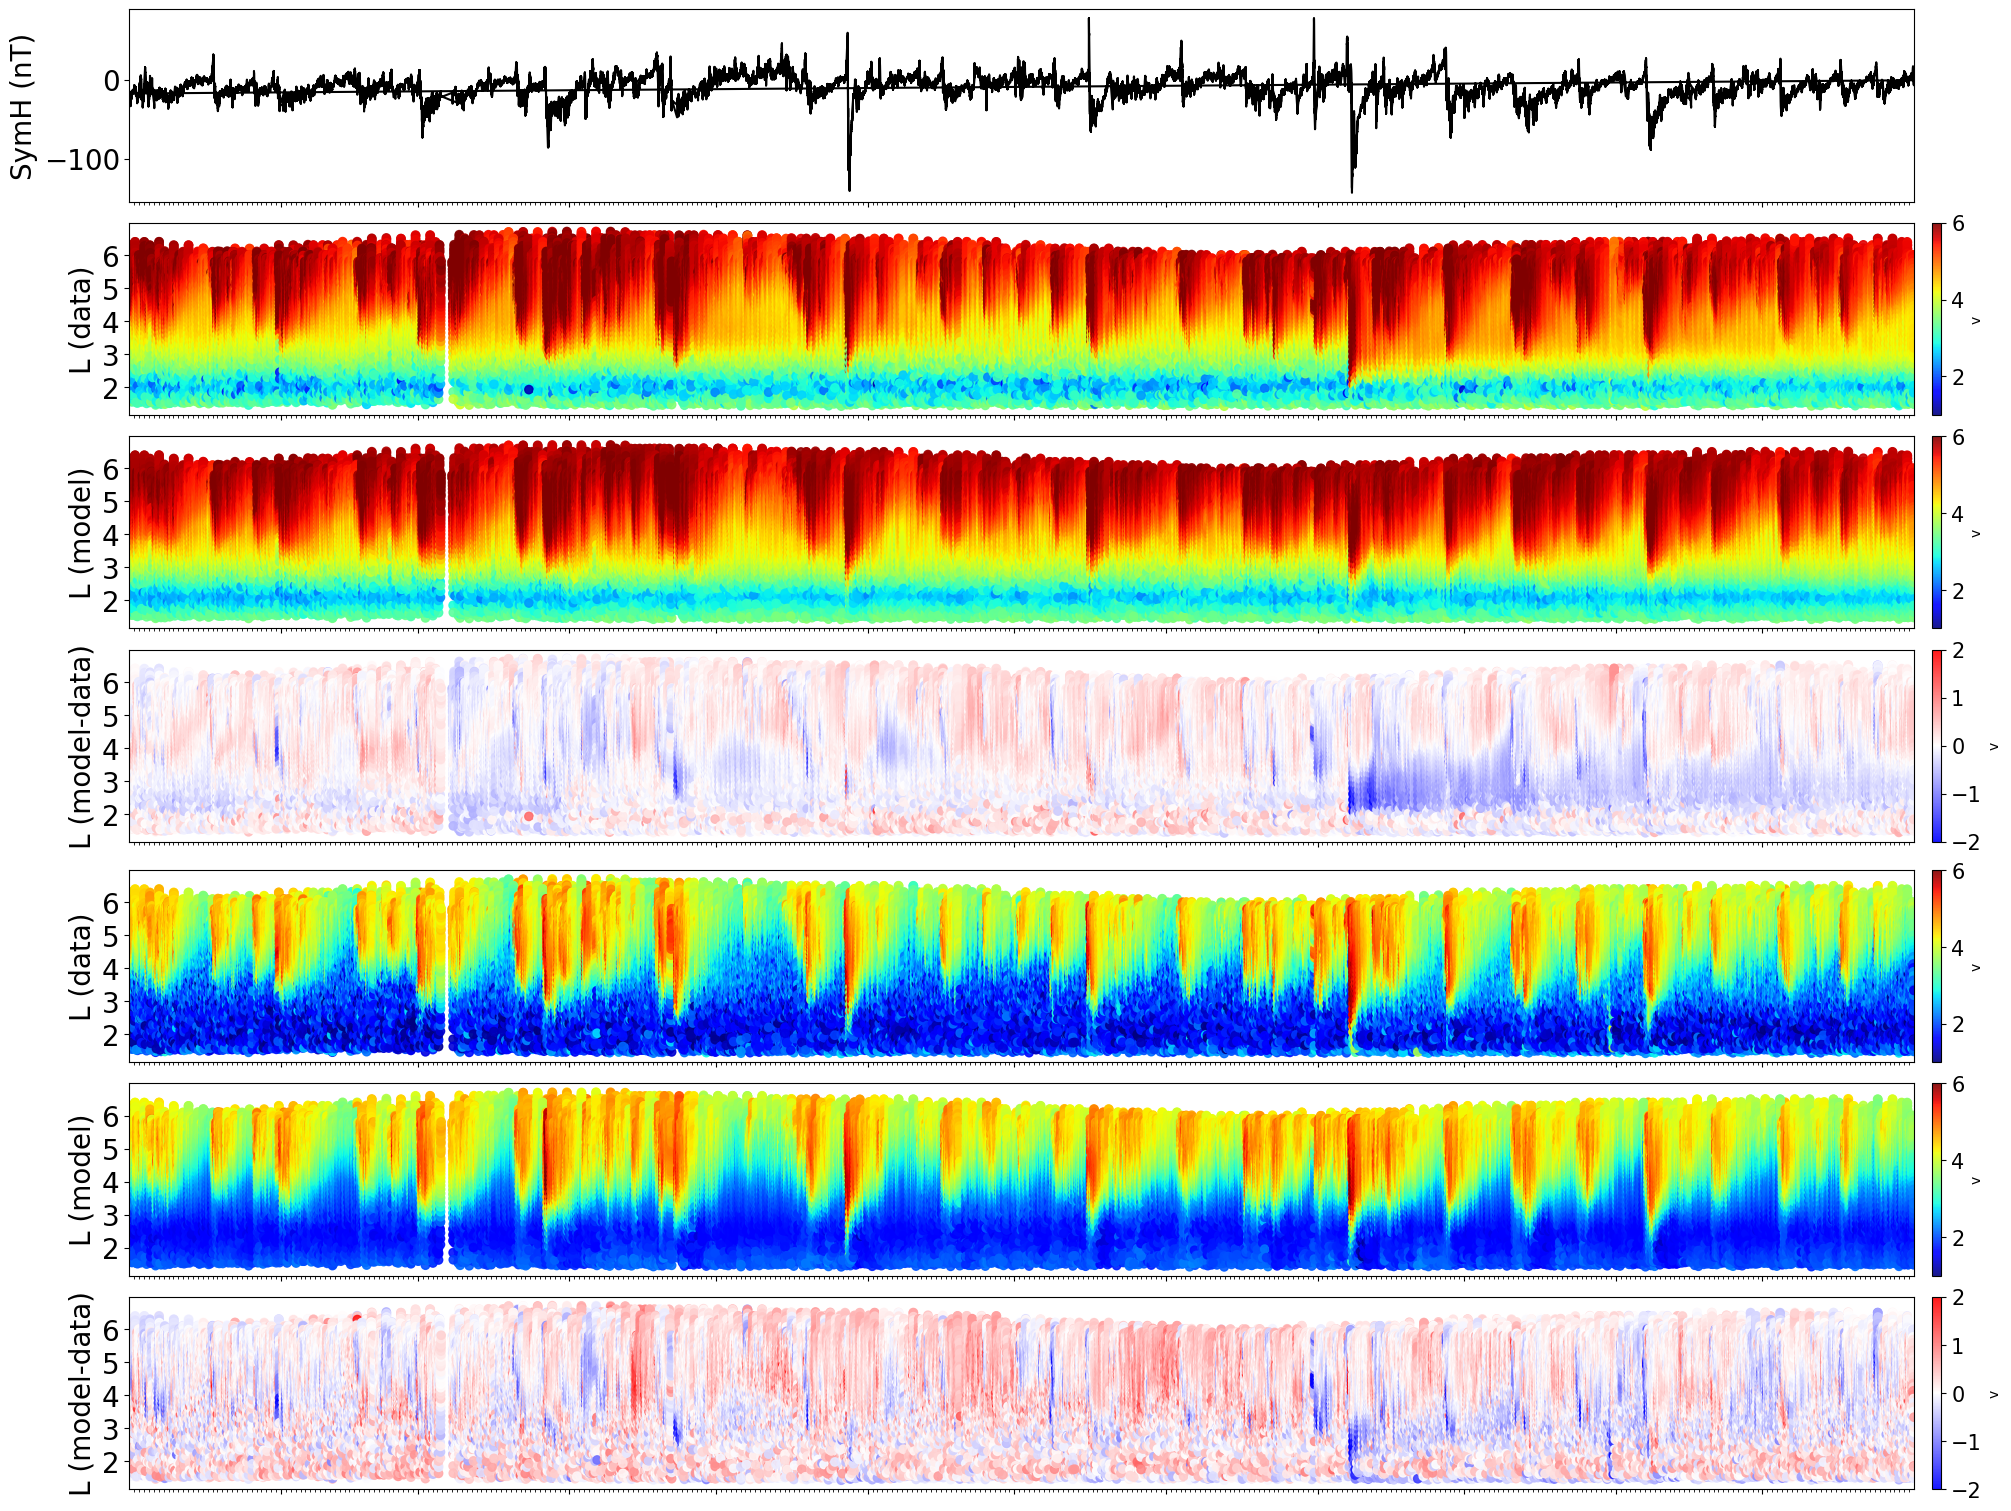

In [111]:
## The following sections are to visulize the long-term variation of modeled proton flux
importlib.reload(plot_functions)

omni_ts, y_data_ts, y_pred_ts, y_diff_ts = plot_functions.create_time_series_variables(df_full, index_test, y_names, y_test_pred_reshaped, to_plot_omni_list=['symh'], to_plot_omni_label_list = ['SymH (nT)'])

plot_functions.plot_test_tplot(omni_ts, y_data_ts, y_pred_ts, y_diff_ts, filename = result_dir +'test_result')